### Plot SIE timeseries

#### Purpose: Plot timeseries of Arctic-wide sea-ice extent

#### Modules and functions

In [4]:
import numpy as np
import pylab as plt
import xarray as xr
import os,sys
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyproj
import pandas as pd
import datetime
import glob
import matplotlib.dates as mdates
import calendar
from scipy.stats import linregress
import pymannkendall as mk

In [3]:
def makenice(ax):
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('SIC', fontsize=14)
    #ax.legend(fontsize=12, loc='upper left')
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Improve x-axis formatting
    plt.xticks(rotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
    # Set major ticks to every year
    ax.xaxis.set_minor_locator(mdates.YearLocator())

In [8]:
def get_dirs():
    if os.path.exists("/Users/vludwig/"):
        basedir = "/Users/vludwig/06_HAUSGARTEN/02_DATA"
        plotdir = "/Users/vludwig/06_HAUSGARTEN/03_PLOTS/"
        datadir_csv = os.path.join(basedir,"01_CSV")
        #datadir_nc = os.path.join(basedir,"02_NETCDF/01_MONTHLY")
        datadir_nc = os.path.join(basedir,"02_NETCDF/02_MONTHLY_OWN")
    else:
        basedir = "/albedo/work/user/vludwig/06_HAUSGARTEN/02_DATA"
        plotdir = "/albedo/home/vludwig/06_HAUSGARTEN/03_PLOTS/"
        datadir_csv = os.path.join(basedir,"01_CSV")
        datadir_nc = "/albedo/work/user/vludwig/05_SINXS/02_DATA/00_MISC/osisaf/monthly/"
    return basedir,plotdir,datadir_csv,datadir_nc

#### Load data

In [19]:
firstyear = 1999
lastyear = 2024
month = 9

In [20]:
today = datetime.datetime.strftime(datetime.datetime.now(),"%Y%m%d")

In [32]:
basedir,plotdir_tmp,datadir_csv,datadir_nc = get_dirs()
plotdir = os.path.join(plotdir_tmp,"02_MAPS")

In [22]:
fns_1999 = [fn for fn in glob.glob(os.path.join(datadir_nc,f"ice_conc_nh_ease2-250_cdr-v3p0_1999*{month:02}.nc"))]
fns_2000_2024 = [fn for fn in glob.glob(os.path.join(datadir_nc,f"ice_conc_nh_ease2-250_*-v3p0_20*{month:02}.nc"))]
fns = list(np.sort(fns_1999+fns_2000_2024))

In [23]:
ds = xr.open_mfdataset(fns)

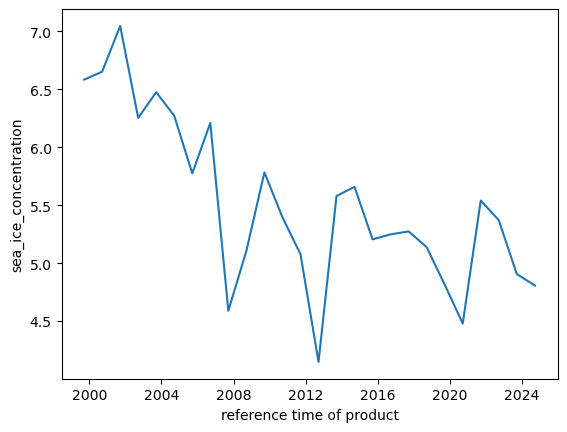

In [24]:
threshold = 15  # Percent

# Define grid cell area if available (can also compute based on lat/lon, here assumed constant)
# For simplicity, assume the grid cells are uniform and use a constant area (km² or m²).
grid_cell_area = 25*25  # Example area for a grid cell in km² (adjust to actual values)

# Apply the threshold to create a binary mask where sea ice concentration >= 15%
ice_extent_mask = ds.sea_ice_concentration >= threshold

# Multiply the binary mask by the grid cell area to get the ice-covered area
ice_extent_area = ice_extent_mask * grid_cell_area*1e-6

# Sum the area over the spatial dimensions (xc, yc) to get total extent for each time step
sea_ice_extent_timeseries = ice_extent_area.sum(dim=['xc', 'yc'])

# Convert the result to a pandas DataFrame or plot it
sea_ice_extent_timeseries.plot()

In [29]:
calendar.month_name[month]

'September'

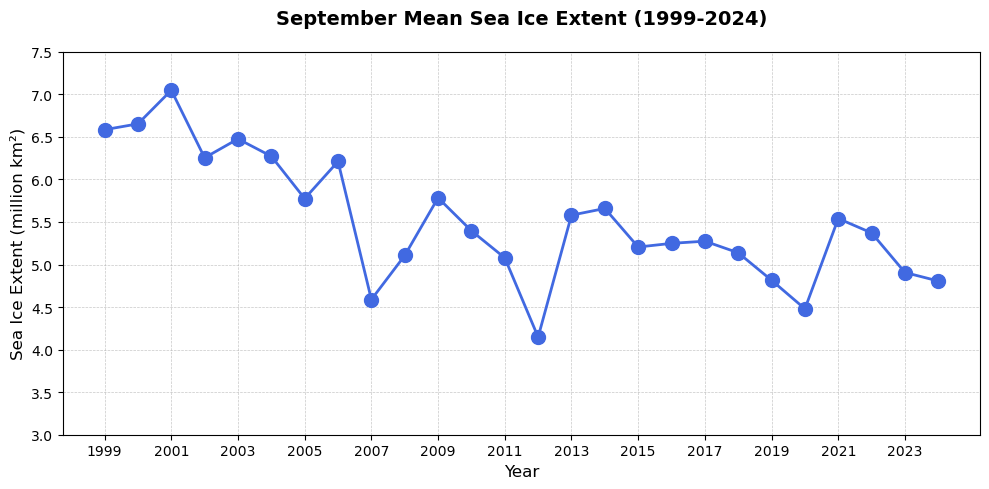

In [35]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the sea ice extent timeseries (assuming sea_ice_extent_timeseries is an xarray DataArray)
ax.plot(sea_ice_extent_timeseries.time.dt.year, sea_ice_extent_timeseries.values, color='royalblue', 
        label='Sea Ice Extent',marker = ".", linewidth=2,markersize = 20)

# Add gridlines with a bit of transparency
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Label axes
ax.set_xlabel('Year', fontsize=12)
ax.set_ylim((3,7.5))
#ax.set_xlim(pd.Timestamp('1996-01-01'), pd.Timestamp('2028-12-31'))
#xticks = pd.date_range(start='1997-09-16', end='2027-09-16', freq='2YS')
ax.set_xticks(sea_ice_extent_timeseries.time.dt.year[::2])
#ax.tick_params(axis = "y",labelcolor = "white",width = 0)
# Set title
ax.set_title(f'{calendar.month_name[month]} Mean Sea Ice Extent ({firstyear}-{lastyear})', fontsize=14, fontweight='bold', pad=20)
ax.set_ylabel('Sea Ice Extent (million km²)', fontsize=12)



# Beautify plot ticks
ax.tick_params(axis='both', which='major', labelsize=10)

# Tight layout for good spacing
plt.tight_layout()
plt.savefig(os.path.join(plotdir,f"sie_osisaf_{month:02}_{today}.pdf"),dpi = 300,bbox_inches = "tight")
# Show the plot
plt.show()


Mann_Kendall_Test(trend='decreasing', h=True, p=0.0001047519237911132, z=-3.879312932197006, Tau=-0.5446153846153846, s=-177.0, var_s=2058.3333333333335, slope=-0.07277777777777786, intercept=6.293472222222222)

#### Plot timeseries

In [124]:
# Define the list of Station IDs you want to filter by
station_ids = ['EG-I', 'EG-II', 'EG-III', 'EG-IV', 'N3', 'N4', 'N5']

In [125]:
## Stations separately
for station_id in station_ids:
    fig, ax = plt.subplots(figsize=(12, 6))
    if os.path.exists(os.path.join(datadir_csv,f"hausgarten_sic_mean_std_{station_id}_1999-2024.csv")):
        df_station = pd.read_csv(os.path.join(datadir_csv,f"hausgarten_sic_mean_std_{station_id}_1999-2024.csv"))
        makeplot(ax,df_station)
        plt.tight_layout()
        fig.savefig(os.path.join(plotdir,f"hausgarten_sic_mean_std_{station_id}_1999-2024.pdf"),dpi = 150,bbox_inches = "tight")
# Plot the mean values with error bars
        plt.close(fig)

In [126]:
viridis_colors = plt.cm.viridis(np.linspace(0,1,7))

In [127]:

df_hausgarten = pd.read_excel(os.path.join(datadir_csv,"average HG-Stations.xlsx"))
# Select rows where "Station ID" is in the specified list
hausgarten_ice = df_hausgarten[df_hausgarten['Station ID'].isin(station_ids)]
hausgarten_ice["lat_decimal"] = [convert_to_decimal_degrees(coordstr) for coordstr in hausgarten_ice["average lat"]]
hausgarten_ice["lon_decimal"] = [convert_to_decimal_degrees(coordstr) for coordstr in hausgarten_ice["average long"]]
londict,latdict = get_coorddicts(hausgarten_ice)

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_65115/2025660164.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hausgarten_ice["lat_decimal"] = [convert_to_decimal_degrees(coordstr) for coordstr in hausgarten_ice["average lat"]]
/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_65115/2025660164.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hausgarten_ice["lon_decimal"] = [convert_to_decimal_degrees(coordstr) for coordstr in hausgarten_ice["average long"]]


In [129]:
if False:
    sic_all = xr.open_mfdataset(os.path.join("/albedo/work/user/vludwig/05_SINXS/02_DATA/00_MISC/osisaf/monthly/","ice_conc_nh*"))
    sic_mean = sic_all.sea_ice_concentration.mean(dim = "time")
    x_2d,y_2d = np.meshgrid(sic_mean.coords["xc"],sic_mean.coords["yc"])
    lon_2d,lat_2d = XY_To_LatLon(x_2d,y_2d,projstring = "+proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs")

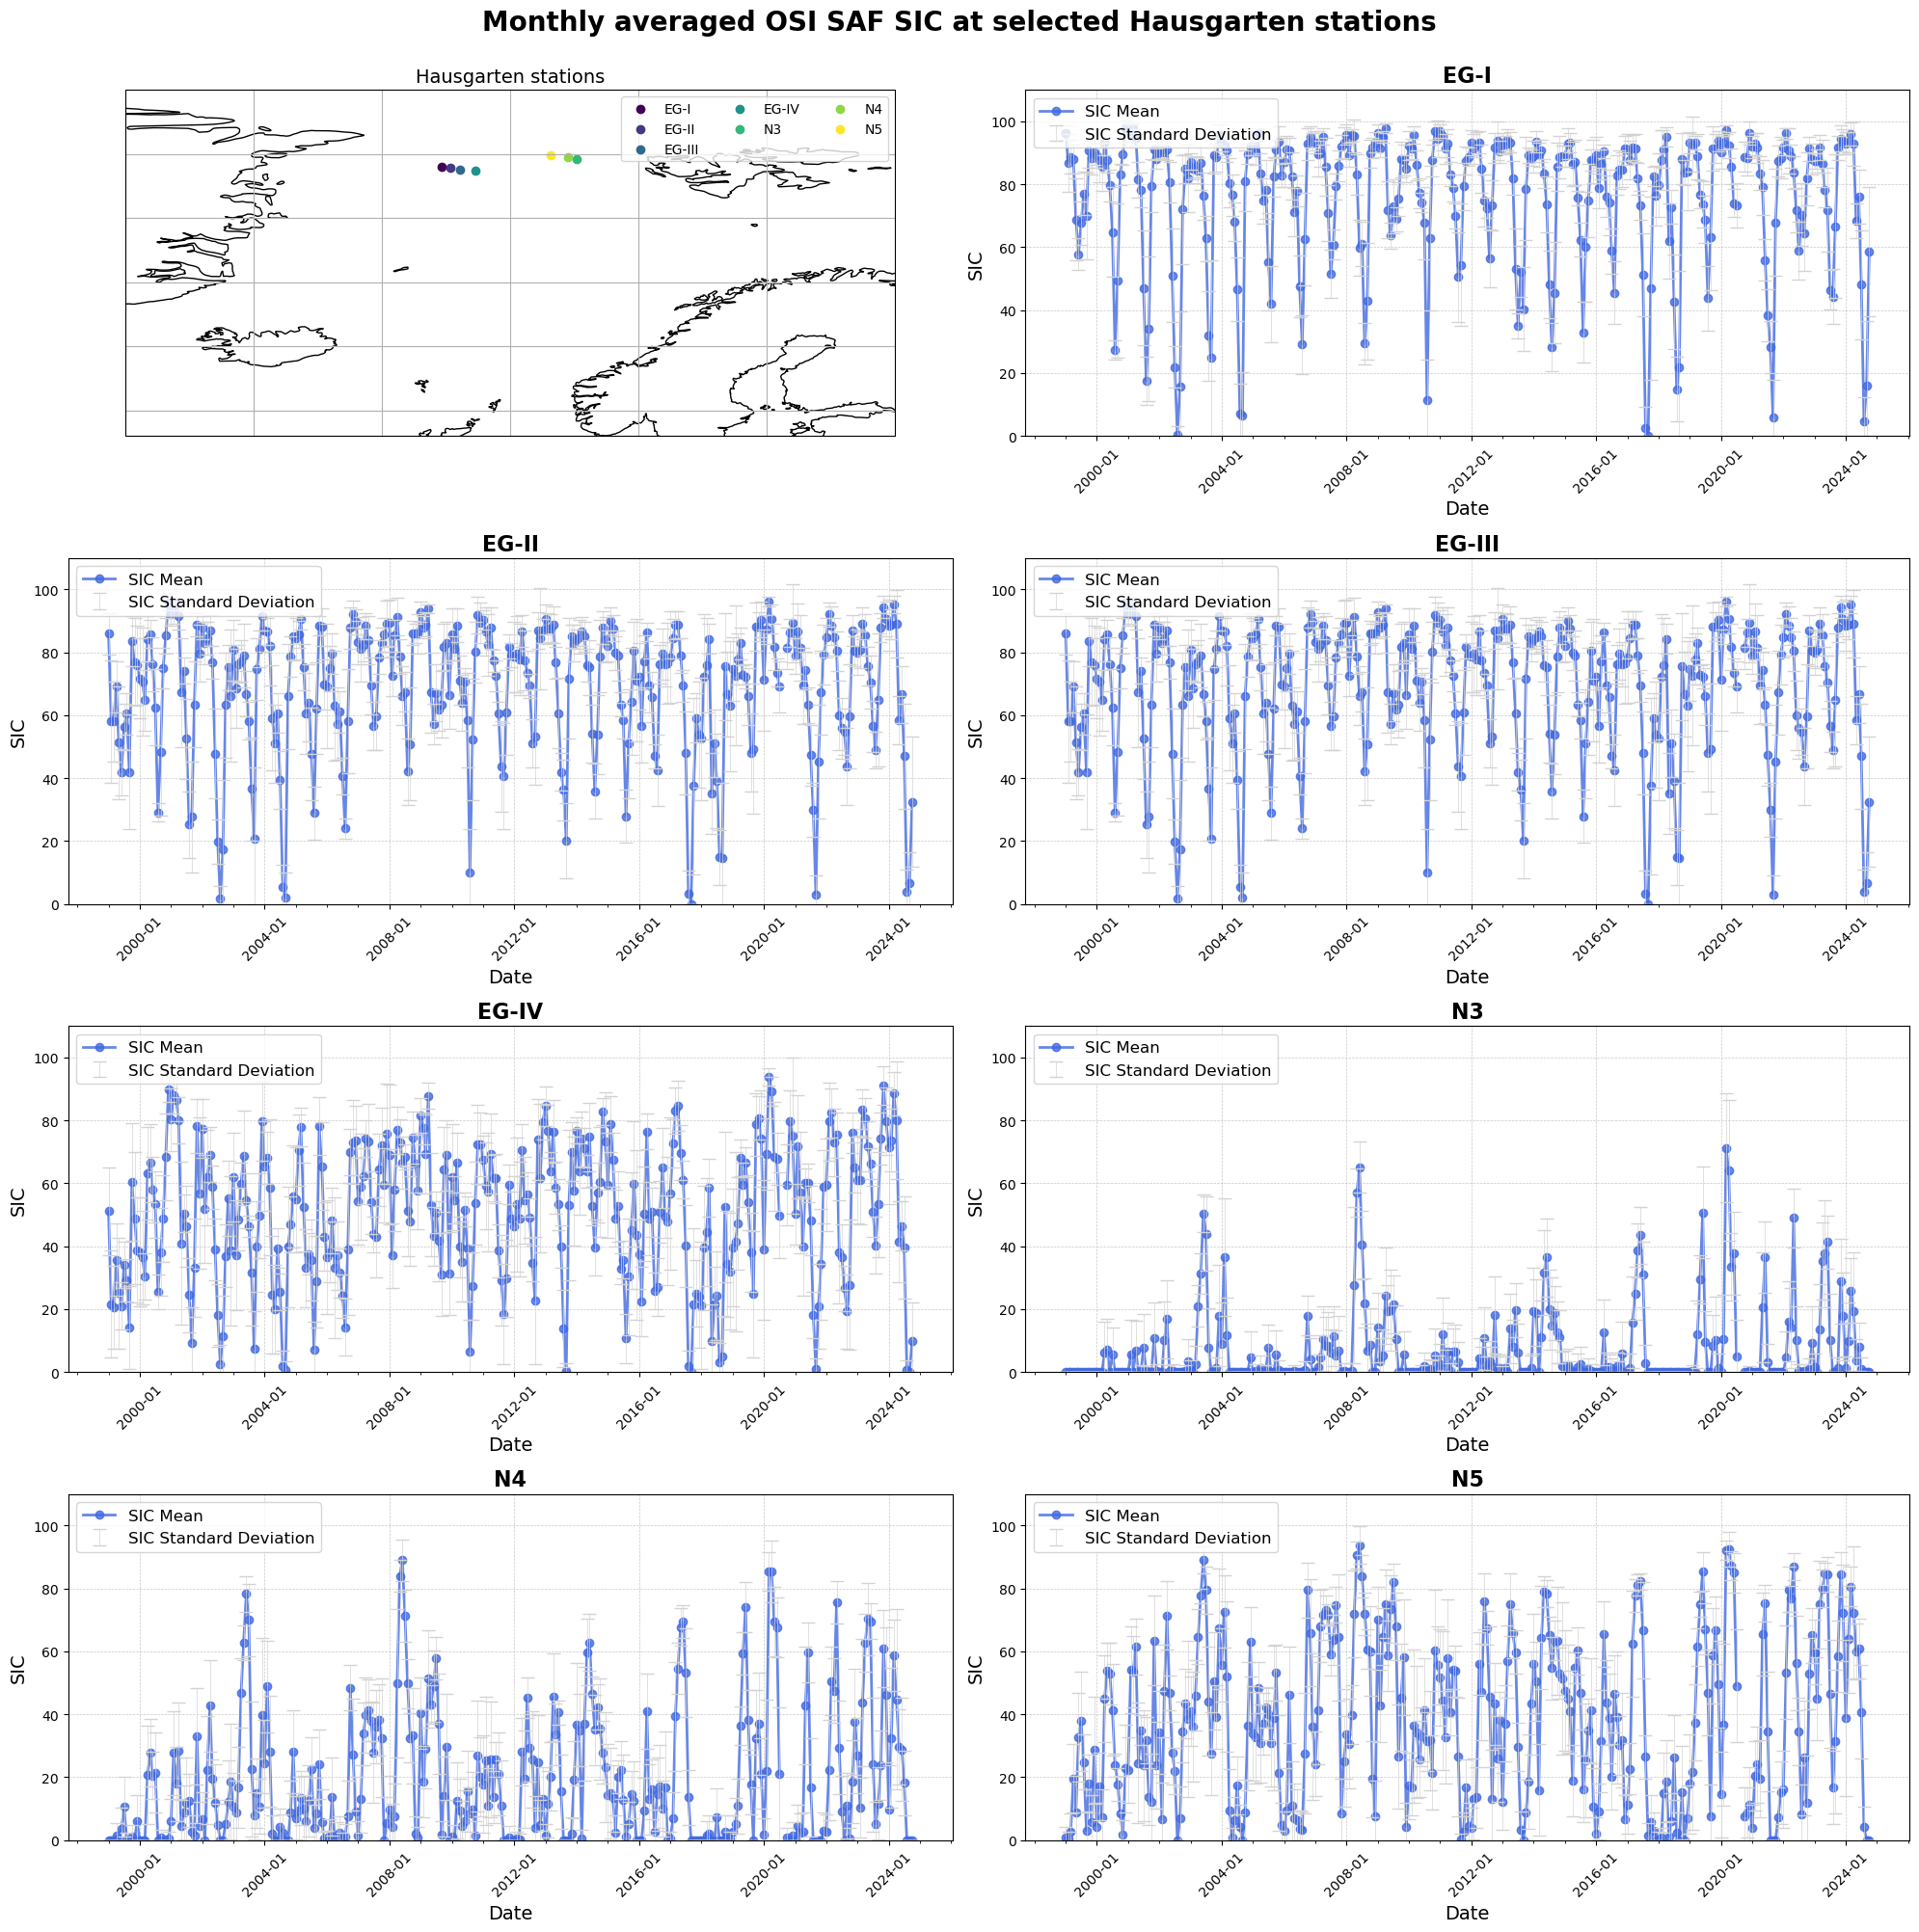

In [136]:
## Stations subplot
fig = plt.figure(figsize = (20,20))
fig.suptitle("Monthly averaged OSI SAF SIC at selected Hausgarten stations",fontweight = "bold",fontsize = 20,y = 1)
ax = fig.add_subplot(421,projection=ccrs.PlateCarree())
#ax = fig.add_subplot(421,projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0, central_latitude=90))
#ax.set_extent([-30, 30, 58,85],ccrs.LambertAzimuthalEqualArea(central_longitude=0, central_latitude=90))
design_map(ax,"Hausgarten stations",hemisphere = "nh")
#sic_mean.plot(ax=ax, cmap='Blues', cbar_kwargs={'label': 'Sea Ice Concentration (%)'})
#ax.pcolormesh(lon_2d, lat_2d, sic_mean, cmap='Blues_r', shading='auto',transform = ccrs.PlateCarree())
#fig.show()
#sys.exit()
for i,station_id in enumerate(station_ids):
    ax.scatter(londict[station_id],latdict[station_id], transform = ccrs.PlateCarree(),color = viridis_colors[i],label = station_id)
    #ax.text(dfdict[station_id]["lon"][0],dfdict[station_id]["lat"][0],station_id, transform = ccrs.PlateCarree())
ax.legend(ncol = 3)    
for i,station_id in enumerate(station_ids):
    
    if os.path.exists(os.path.join(datadir_csv,f"hausgarten_sic_mean_std_{station_id}_{firstyear}-{lastyear}.csv")):
        df_station = pd.read_csv(os.path.join(datadir_csv,f"hausgarten_sic_mean_std_{station_id}_{firstyear}-{lastyear}.csv"))
        ax = fig.add_subplot(422+i)
        makeplot(ax,df_station)

plt.tight_layout()
#fig.savefig(os.path.join(plotdir,f"hausgarten_sic_mean_std_ALL_1999-2023.pdf"),dpi = 150,bbox_inches = "tight")
# Plot the mean values with error bars


# Show the plot

plt.show()

#### Compare means between stations

In [137]:
dfdict = get_dfdict(datadir_csv,station_ids)

In [138]:
sic_mean_eg = np.zeros((4,dfdict["EG-I"].shape[0]))
sic_std_eg = np.zeros((4,dfdict["EG-I"].shape[0]))

sic_mean_n = np.zeros((4,dfdict["N3"].shape[0]))
sic_std_n = np.zeros((4,dfdict["N3"].shape[0]))

In [139]:
stations_eg = [s for s in station_ids if s.startswith("EG")]
stations_n = [s for s in station_ids if s.startswith("N")]

In [140]:
for i,station_id in enumerate(stations_eg):
    sic_mean_eg[i,:] = dfdict[station_id]["sic_mean"]
for i,station_id in enumerate(stations_n):
    sic_mean_n[i,:] = dfdict[station_id]["sic_mean"]

In [146]:
date_range = pd.date_range(start=f'{firstyear}-01', end=f'{lastyear}-12', freq='MS')

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_65115/698658679.py:5: RuntimeWarning: All-NaN slice encountered
  ax.plot(date_range,np.nanmax(sic_mean_eg,axis = 0) - np.nanmin(sic_mean_eg,axis = 0),color='royalblue', linestyle='-', marker='o', markersize=6, linewidth=2, alpha=0.8)


ValueError: x and y must have same first dimension, but have shapes (312,) and (300,)

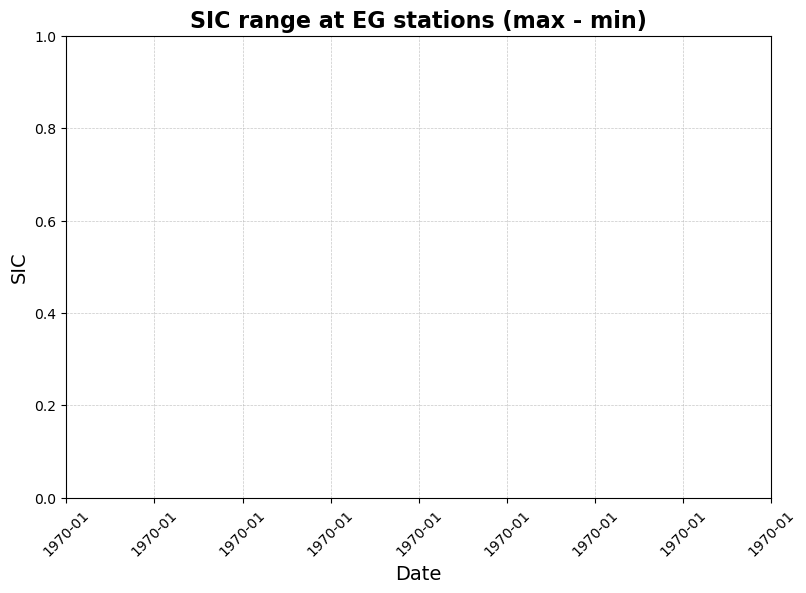

In [147]:
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(121)
ax.set_title(f'SIC range at EG stations (max - min)', fontsize=16, fontweight='bold')
makenice(ax)
ax.plot(date_range,np.nanmax(sic_mean_eg,axis = 0) - np.nanmin(sic_mean_eg,axis = 0),color='royalblue', linestyle='-', marker='o', markersize=6, linewidth=2, alpha=0.8)
ax = fig.add_subplot(122)
ax.set_title(f'SIC range at N stations (max - min)', fontsize=16, fontweight='bold')
makenice(ax)
ax.plot(date_range,np.nanmax(sic_mean_n,axis = 0) - np.nanmin(sic_mean_n,axis = 0),color='royalblue', linestyle='-', marker='o', markersize=6, linewidth=2, alpha=0.8)
fig.savefig(os.path.join(plotdir,f"hausgarten_sic_range_{firstyear}-{lastyear}.pdf"),dpi = 150,bbox_inches = "tight")

fig.show()

#### Monthly plots for each station

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_37568/646311217.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_month['dt'] = pd.to_datetime(df_month[['year', 'month']].assign(day=1))
/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_37568/646311217.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_month['dt'] = pd.to_datetime(df_month[['year', 'month']].assign(day=1))
/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_37568/646311217.py:8: SettingWithCopyWarning: 
A 

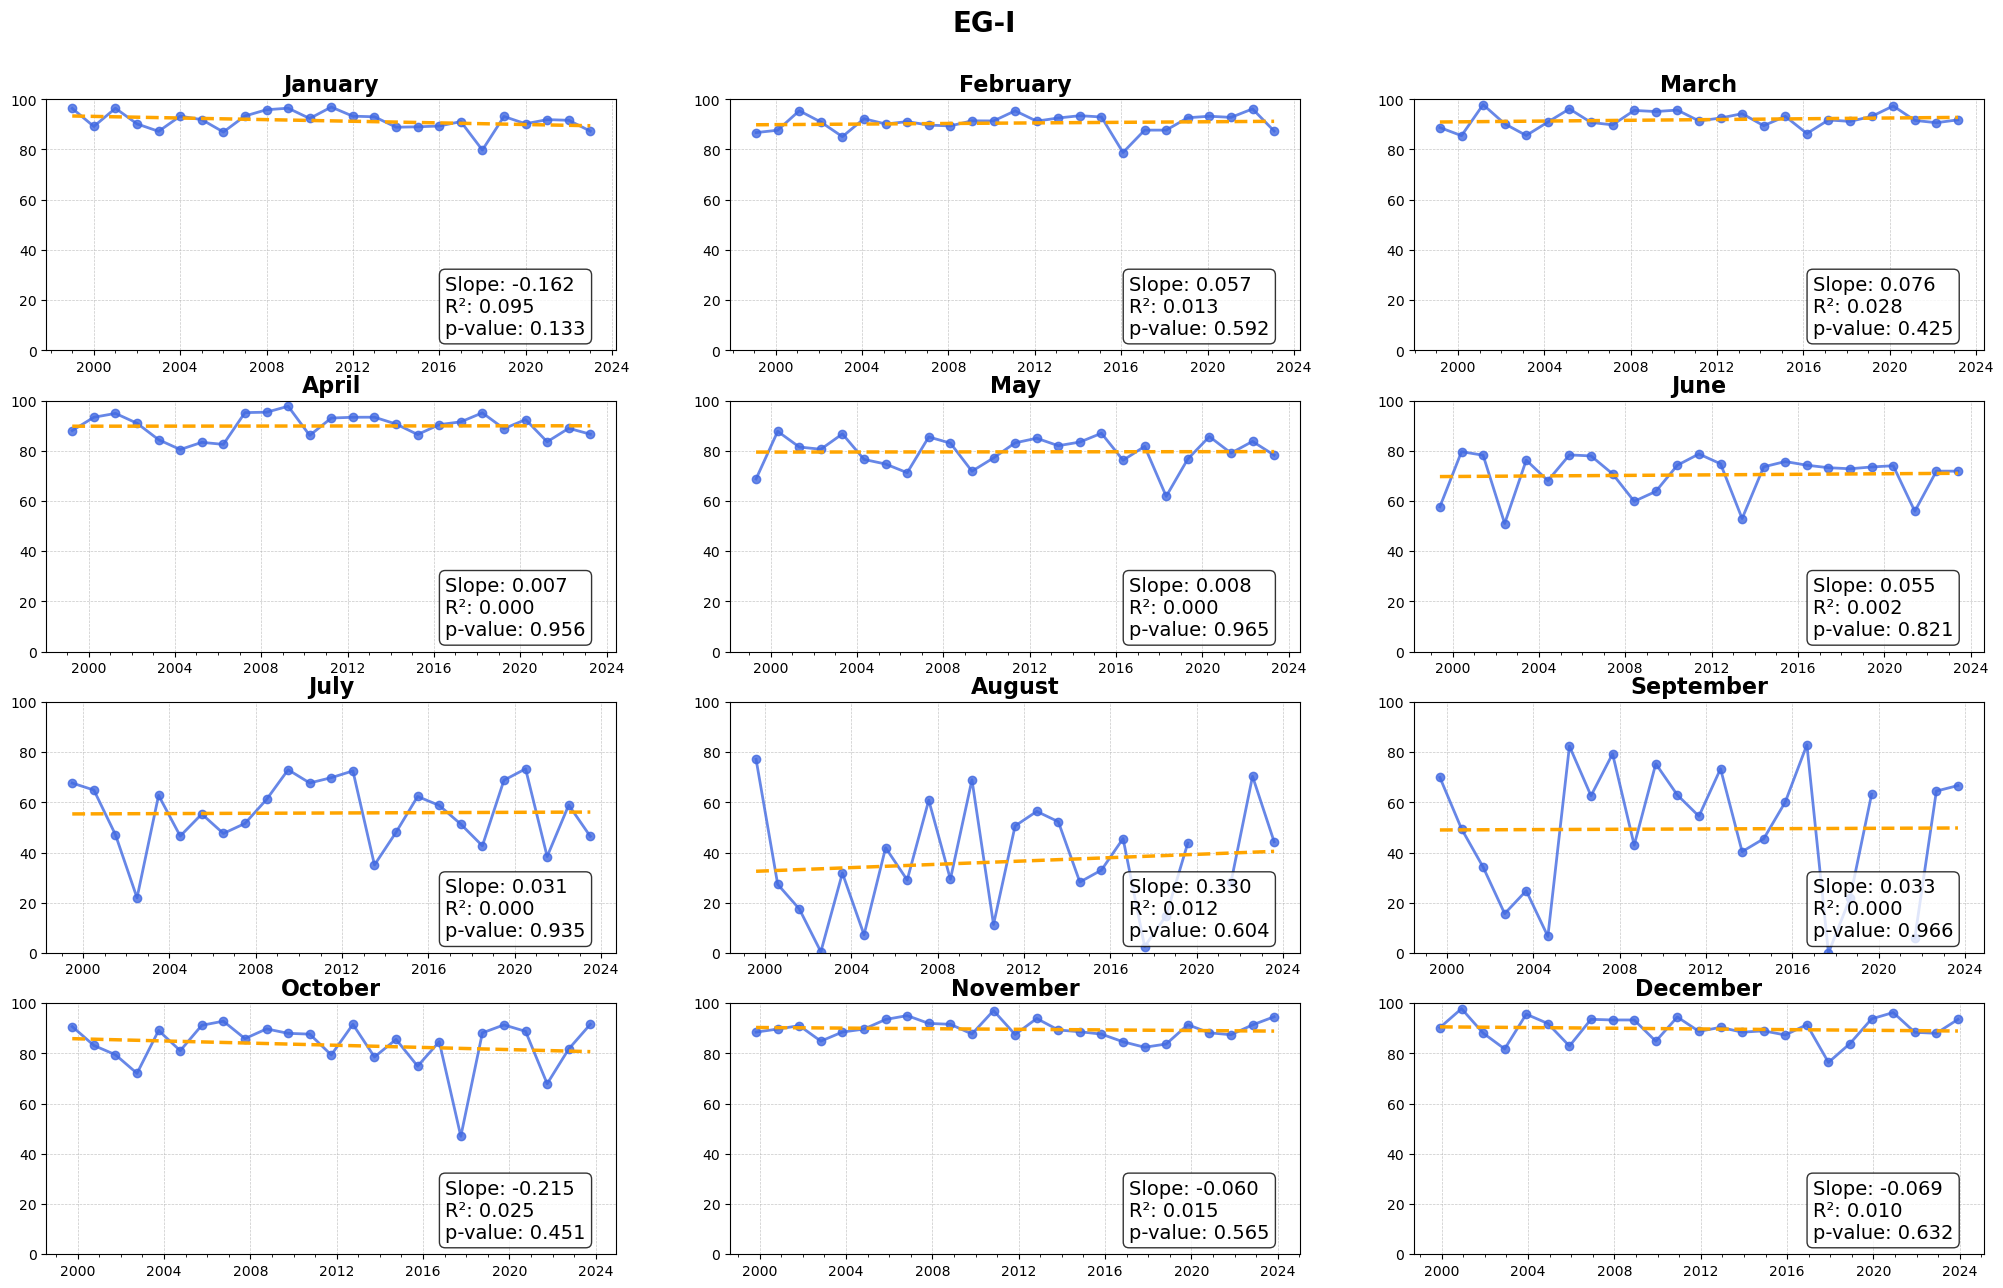

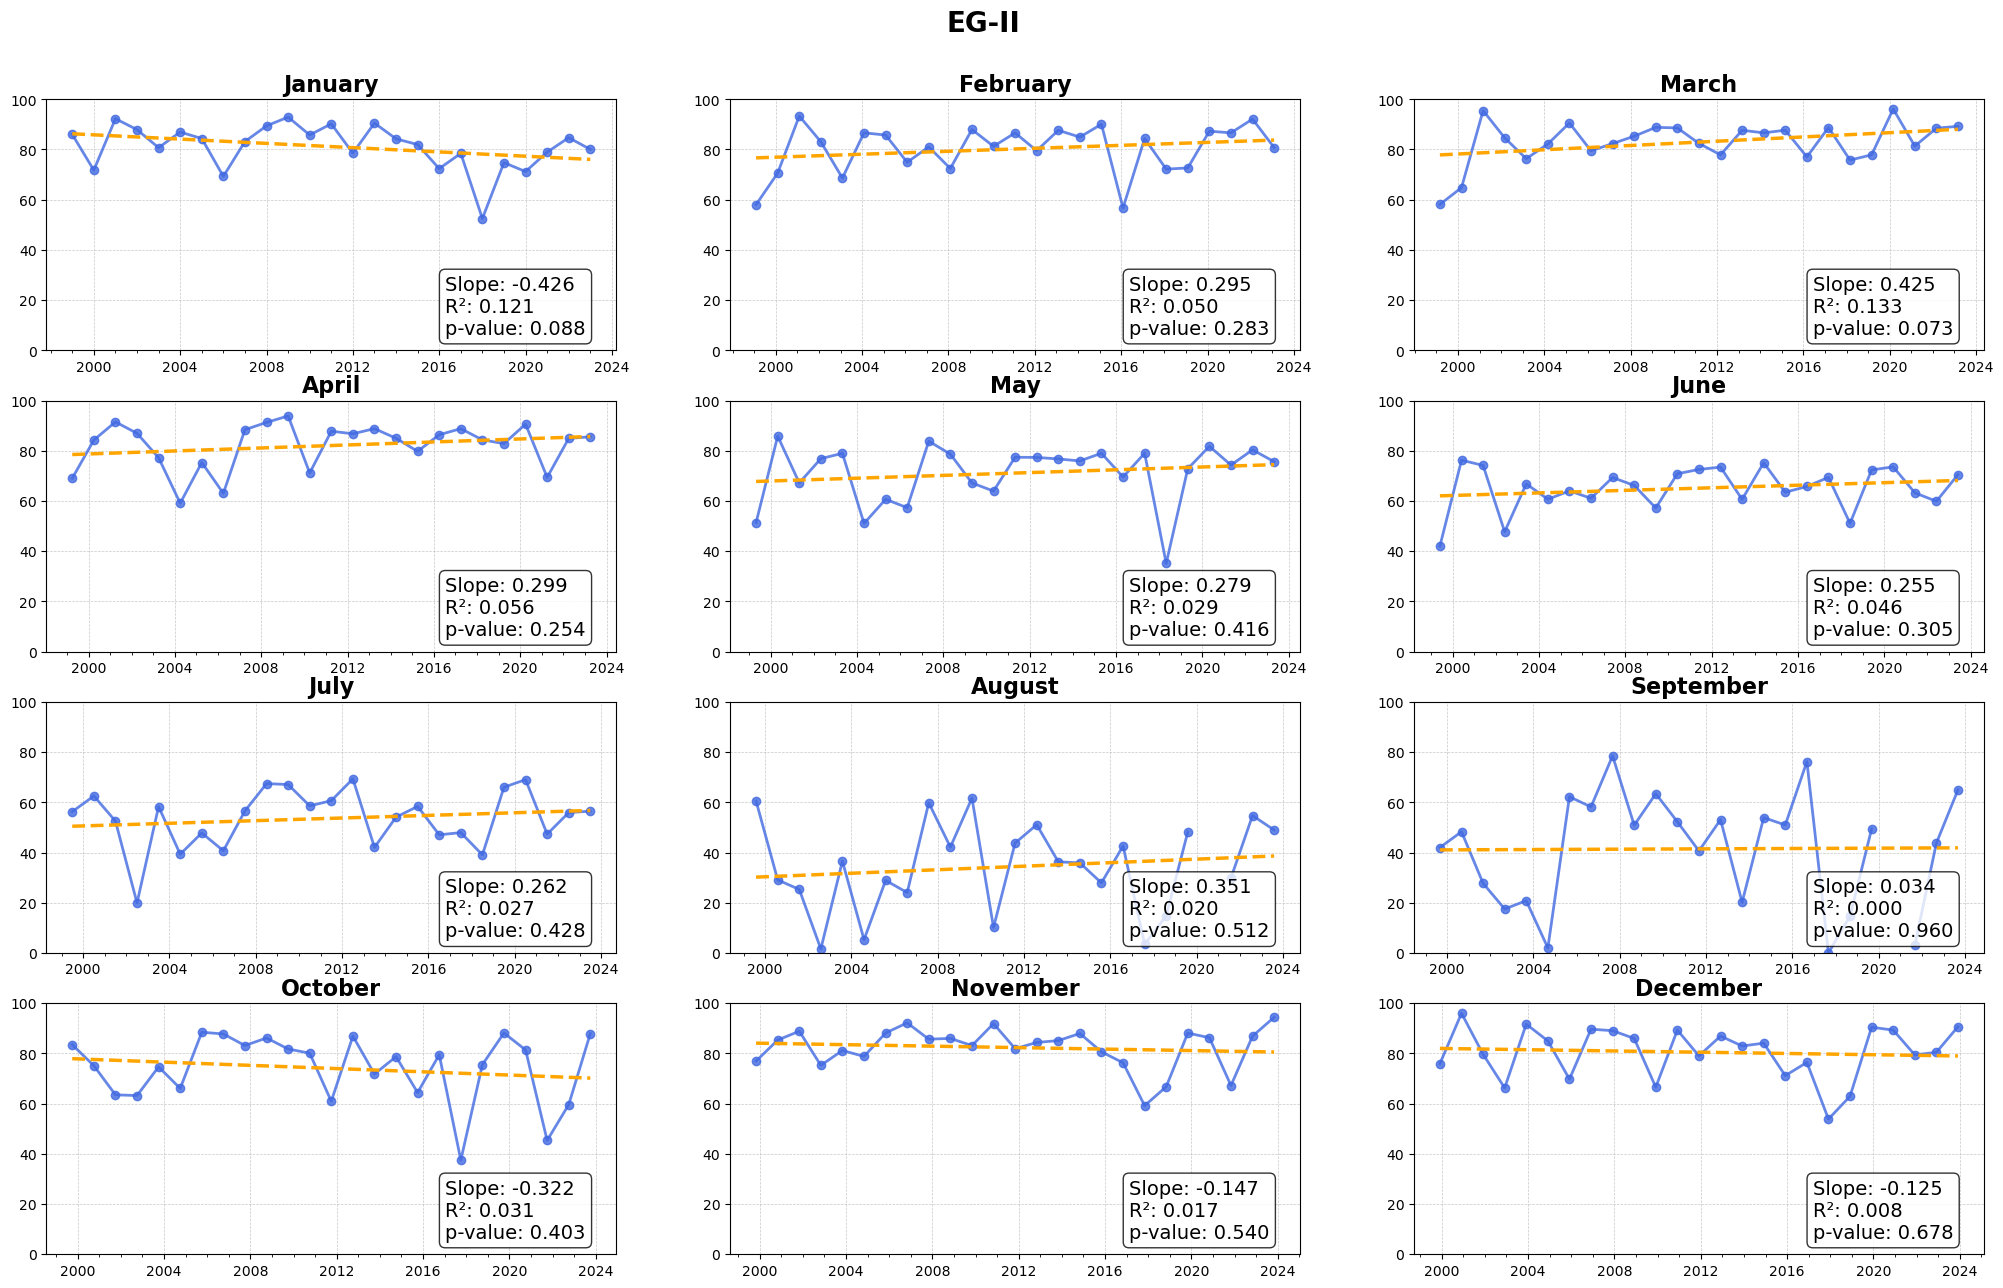

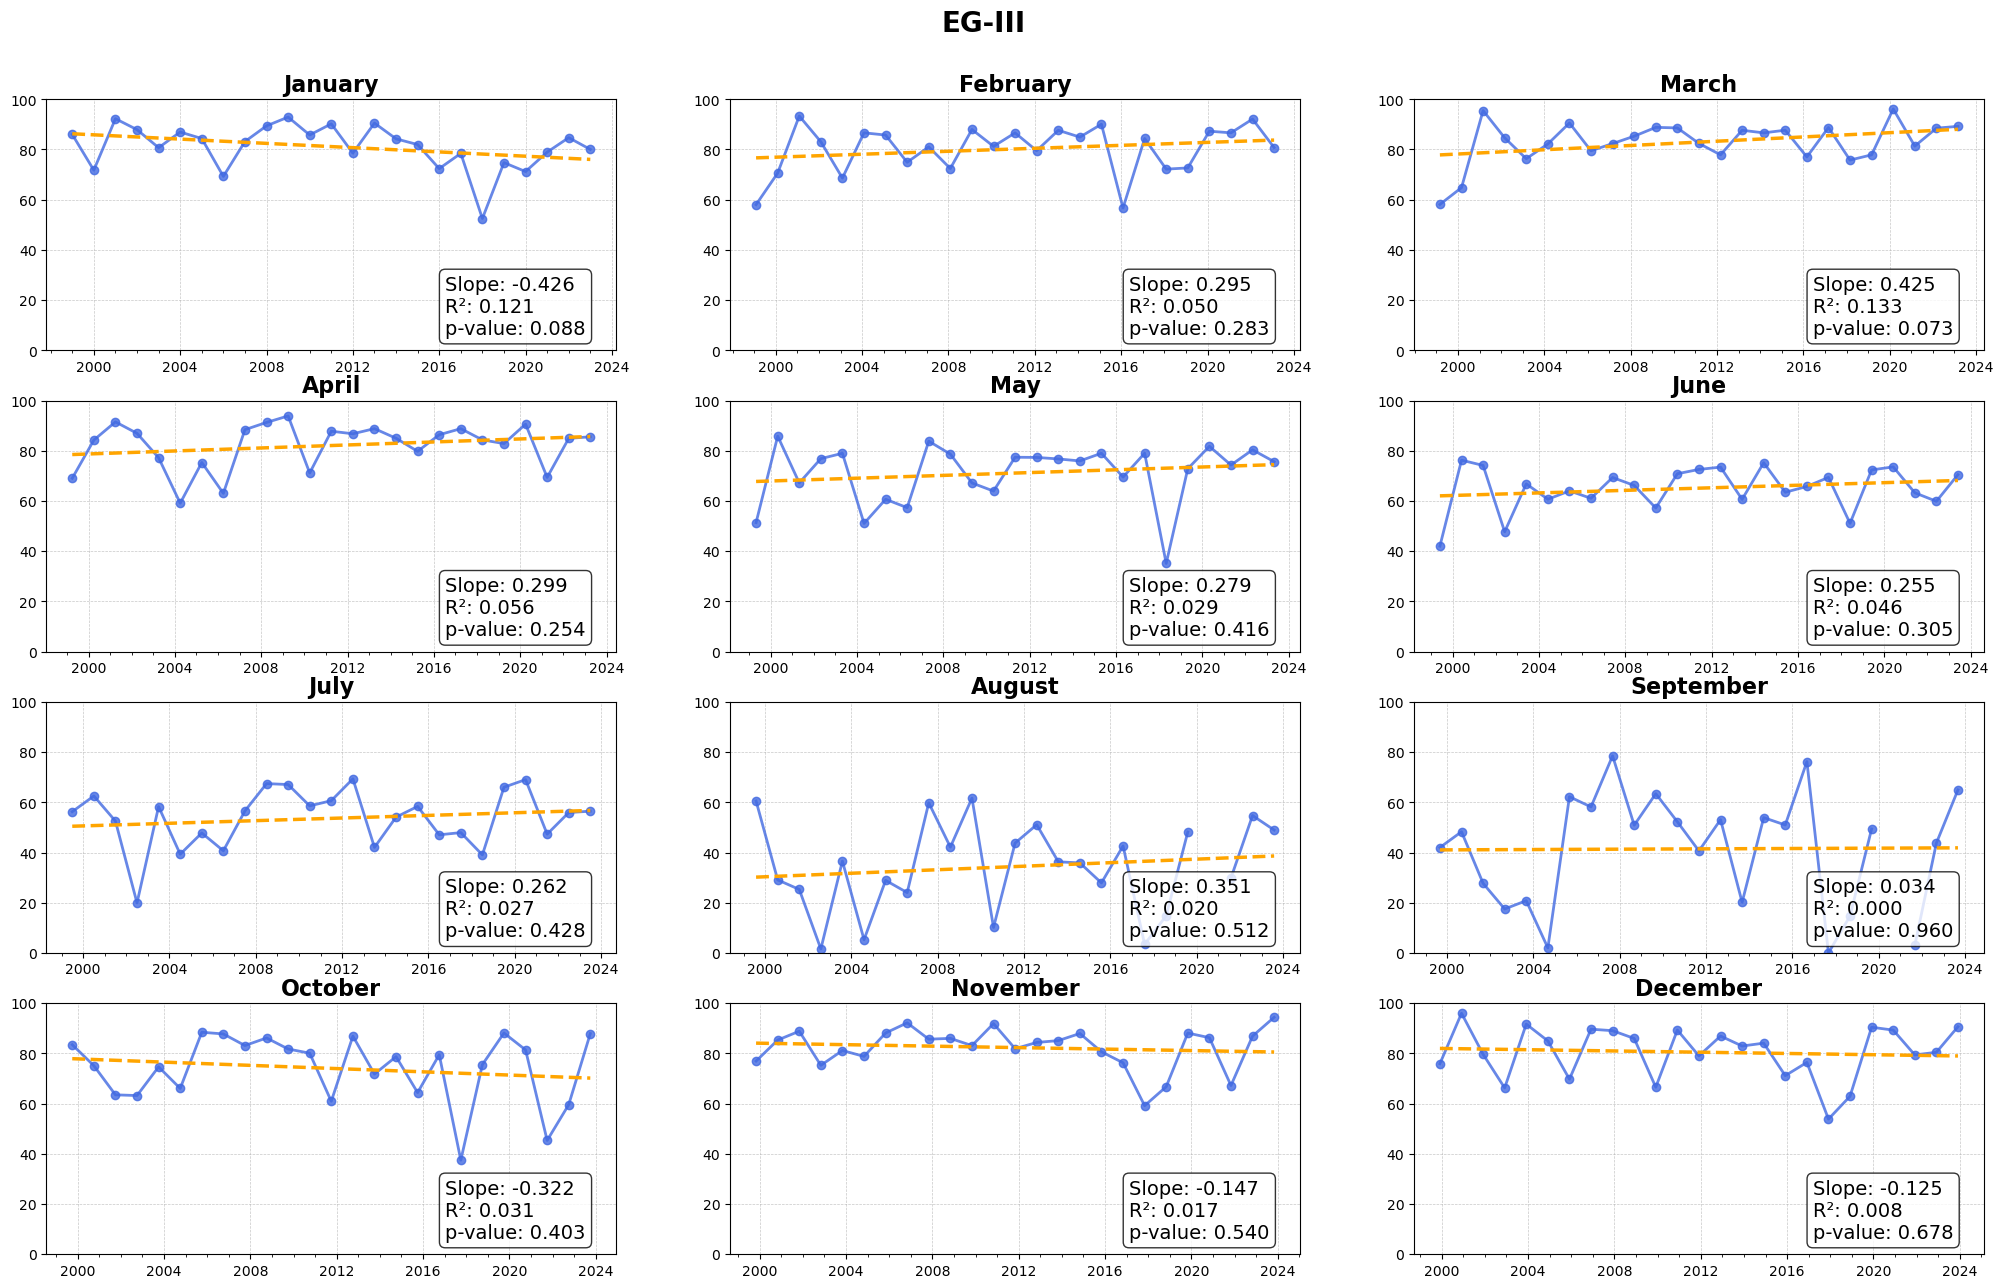

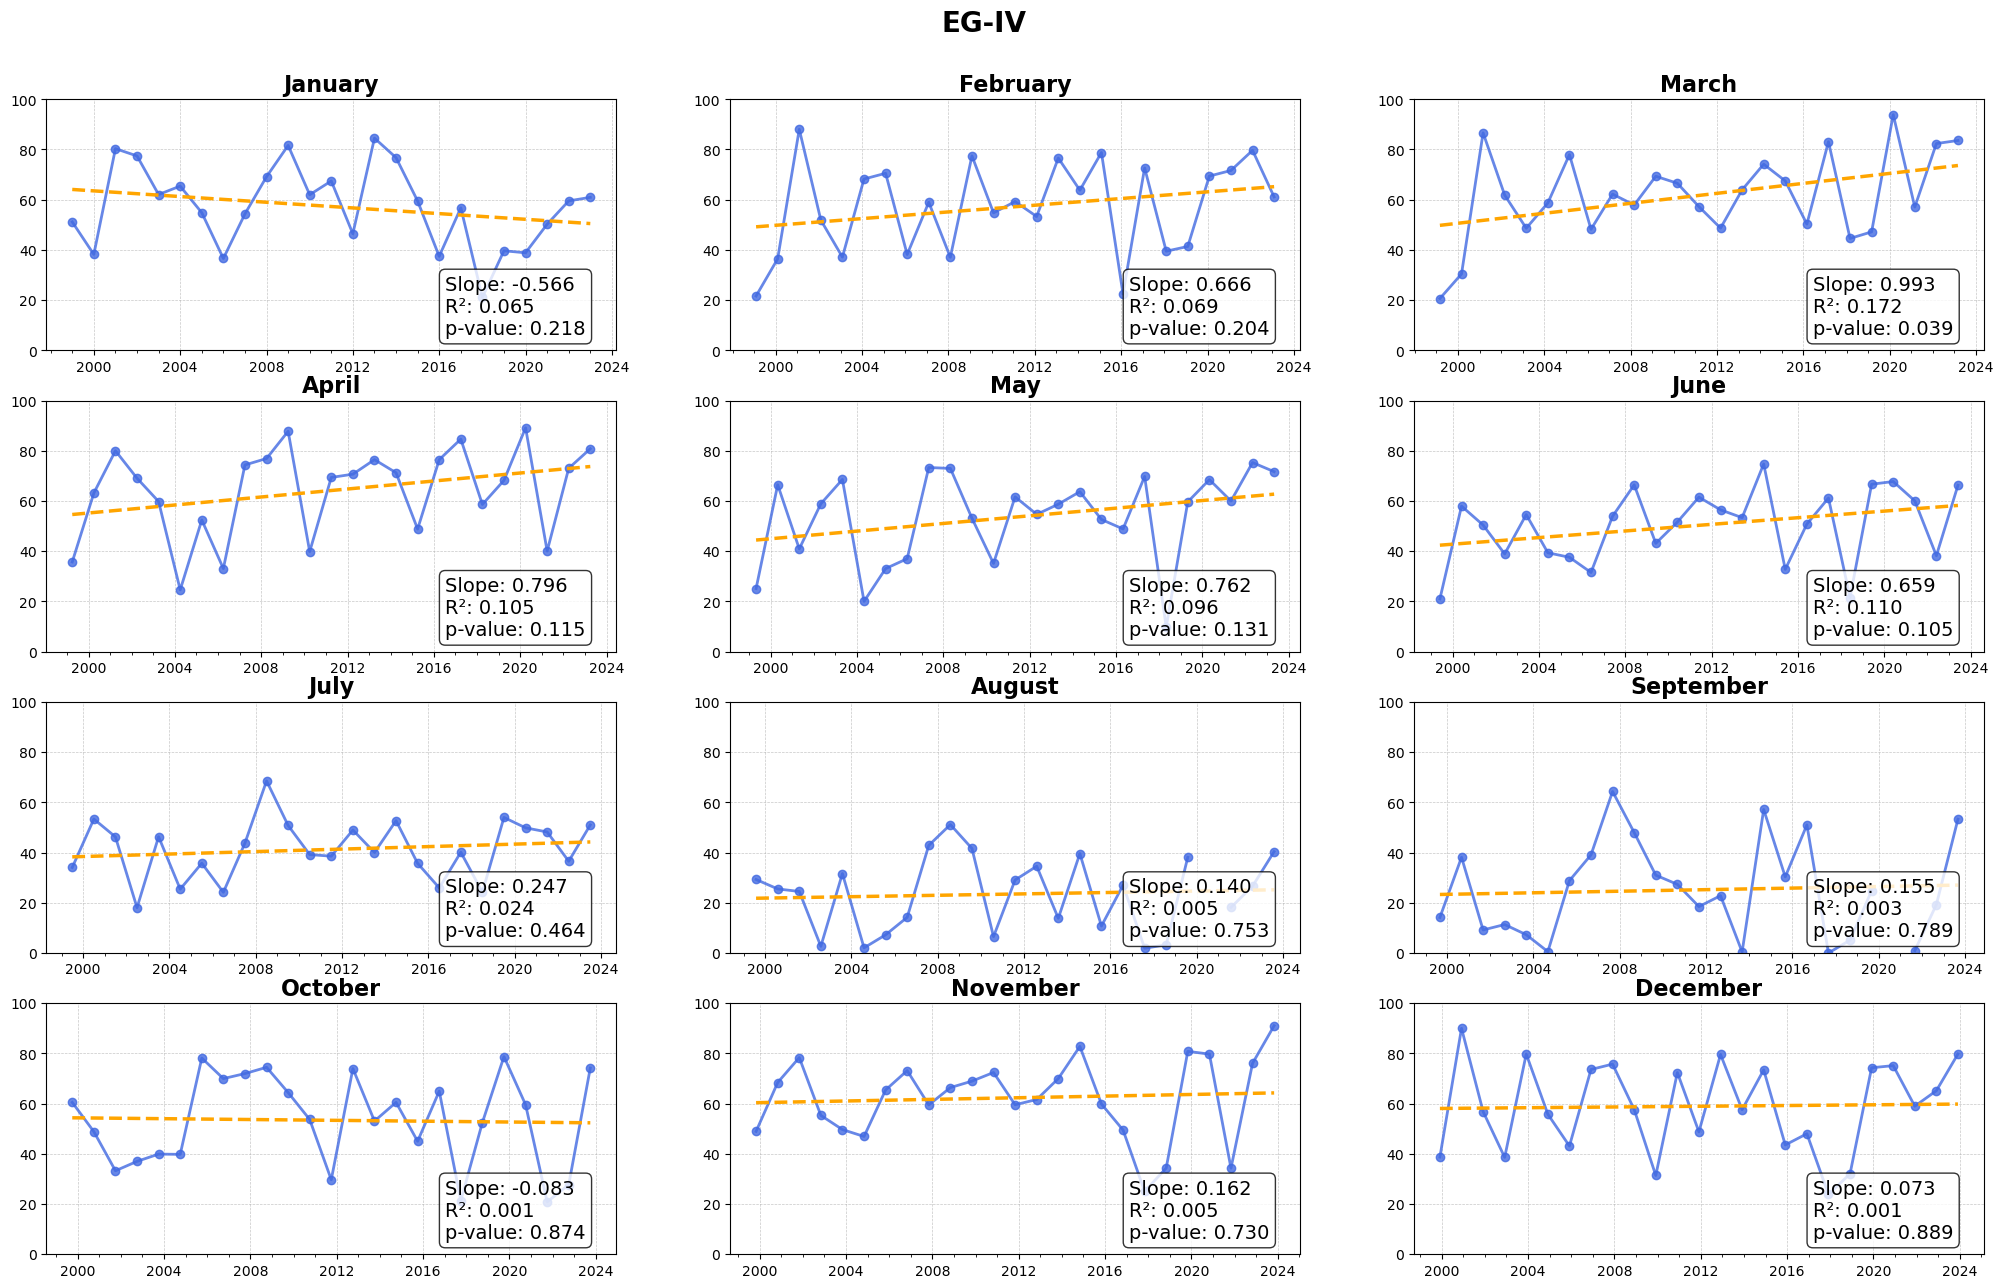

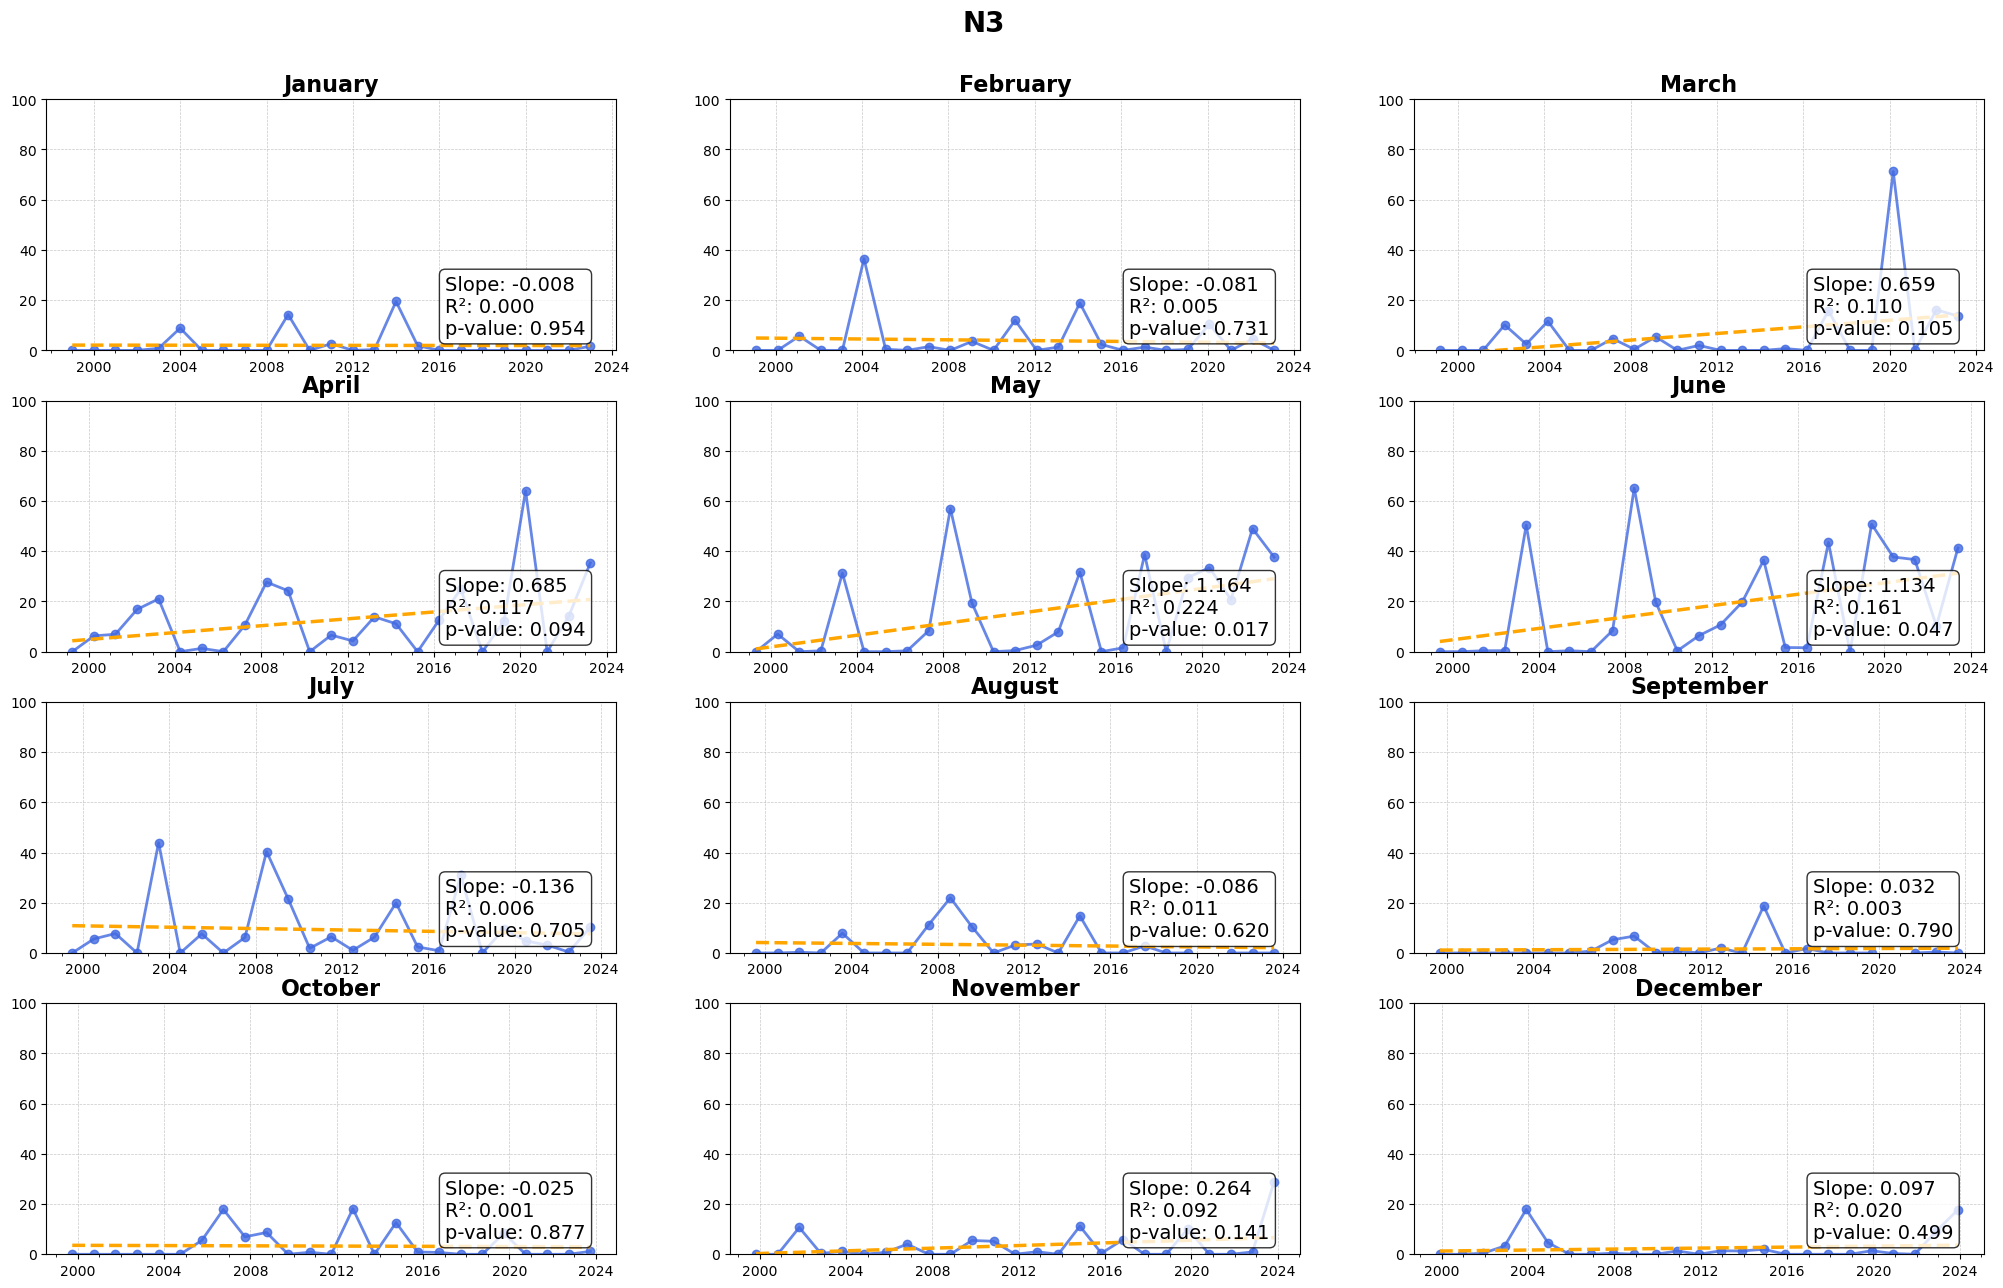

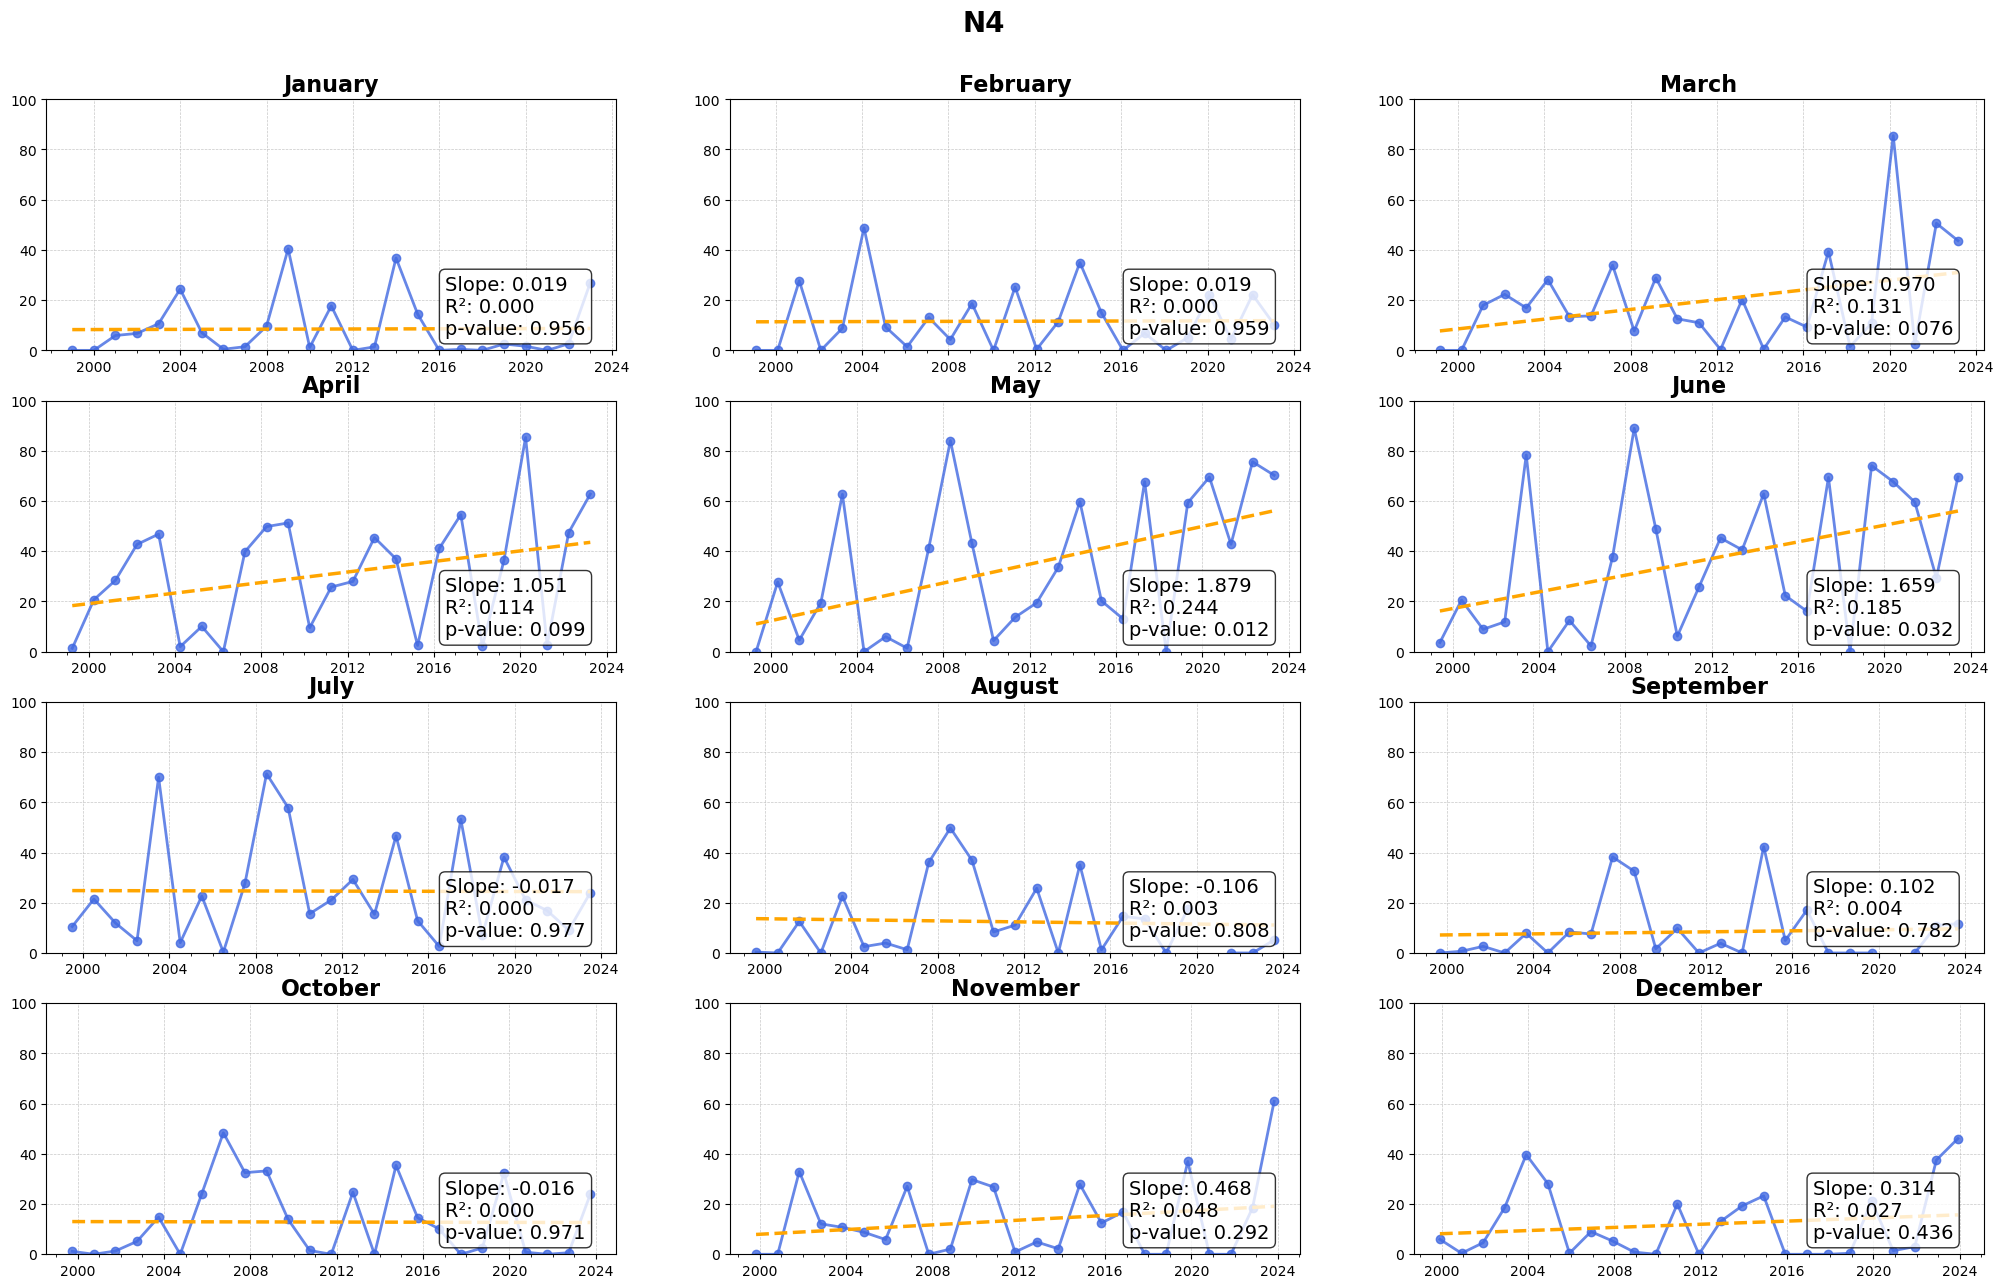

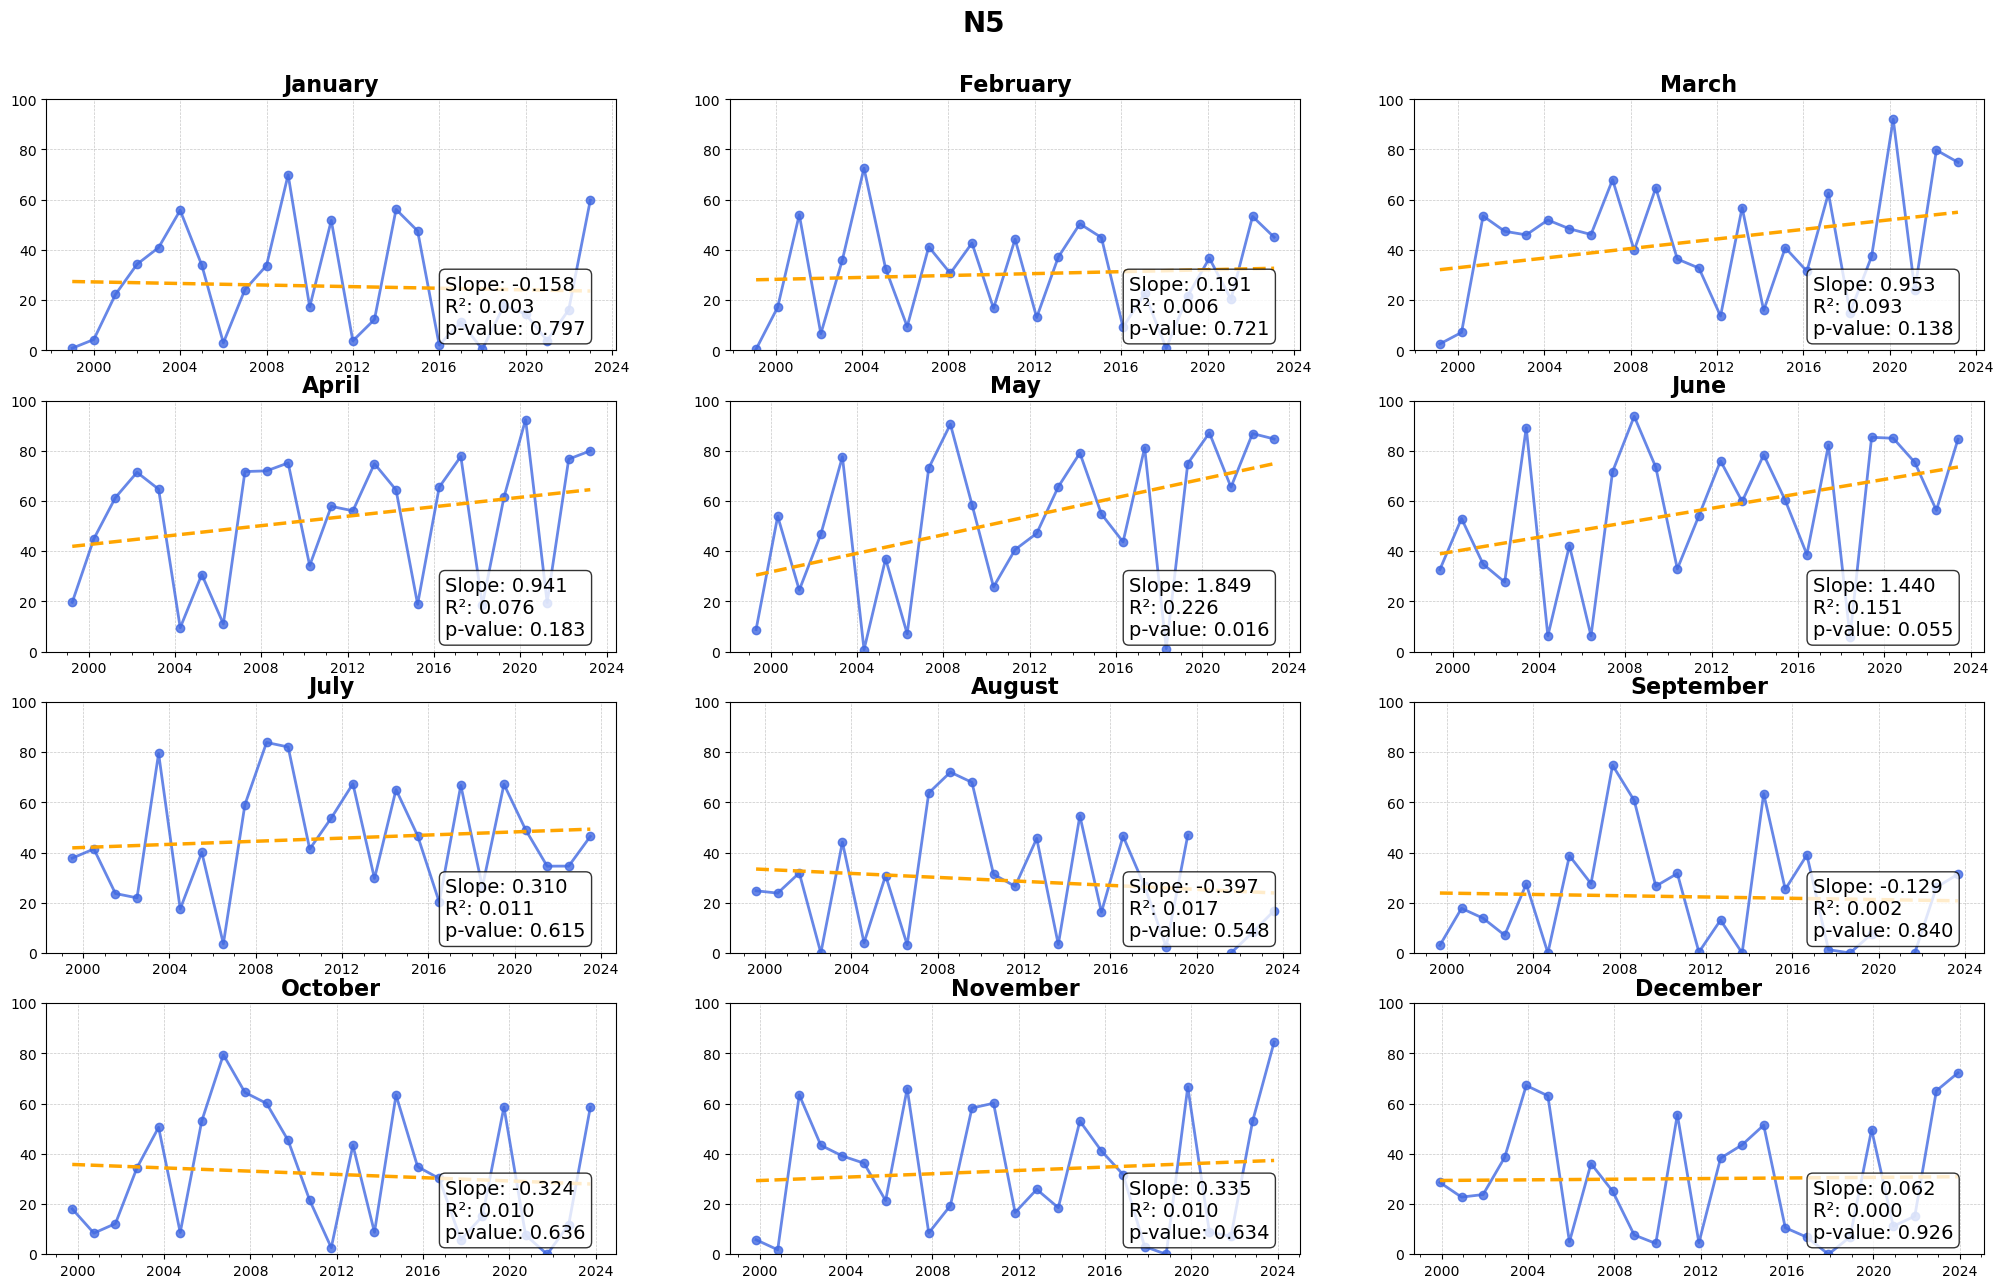

In [68]:
for station_id in station_ids:
    df_station = dfdict[station_id]
    fig = plt.figure(figsize = (25,15))
    fig.suptitle(f'{df_station["station_id"][0]}',fontweight = "bold",fontsize = 20,y = .94)

    for i,month in enumerate(range(1,13)):
        df_month = df_station[df_station["month"] == month]
        df_month['dt'] = pd.to_datetime(df_month[['year', 'month']].assign(day=1))
        # Extract the dt array for plotting
        dt_array = df_month['dt'].values
        
        ax = fig.add_subplot(4,3,month)
        #ax.set_title(, fontsize=16, fontweight='bold')
        ax.plot(dt_array,df_month["sic_mean"],color='royalblue', linestyle='-', marker='o', markersize=6, linewidth=2, alpha=0.8)
        ax.set_ylim((0,100))
        ax.set_title(f'{calendar.month_name[month]}', fontsize=16, fontweight='bold')
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        lr = linregress(df_month["year"][~np.isnan(df_month["sic_mean"])],df_month["sic_mean"][~np.isnan(df_month["sic_mean"])])
        #ax.text(0.75, 0.3, f"Slope: {lr.slope:.3f}", transform=ax.transAxes, fontsize=14, verticalalignment='top', horizontalalignment='left')
        ax.plot(dt_array,range(1999,2024)*lr.slope+lr.intercept, color='orange', linewidth=2.5, linestyle='--')
        stats_text = (f"Slope: {lr.slope:.3f}\n"
                       f"R²: {lr.rvalue**2:.3f}\n"
                       f"p-value: {lr.pvalue:.3f}")
        
        # Box properties for the text
        text_props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.8)
        
        # Add the text with a box around it
        ax.text(0.7, 0.3, stats_text,
                transform=ax.transAxes, fontsize=14,
                verticalalignment='top', horizontalalignment='left',
                bbox=text_props)

        # Improve x-axis formatting
        #plt.xticks(rotation=45)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        
        # Set major ticks to every year
        ax.xaxis.set_minor_locator(mdates.YearLocator())
    #fig.savefig(os.path.join(plotdir,f"hausgarten_sic_mean_{station_id}_by_month_1999-2023.pdf"),dpi = 150,bbox_inches = "tight")
    #plt.close(fig)
    fig.show()
    #sys.exit("ONE STATION")

#### Monthly plots for station average



/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_37568/1346216607.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_month['dt'] = pd.to_datetime(df_month[['year', 'month']].assign(day=1))
/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_37568/1346216607.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_month['dt'] = pd.to_datetime(df_month[['year', 'month']].assign(day=1))
/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_37568/1346216607.py:12: SettingWithCopyWarnin

SystemExit: ONE STATION

/Users/vludwig/opt/anaconda3/envs/sinxs/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


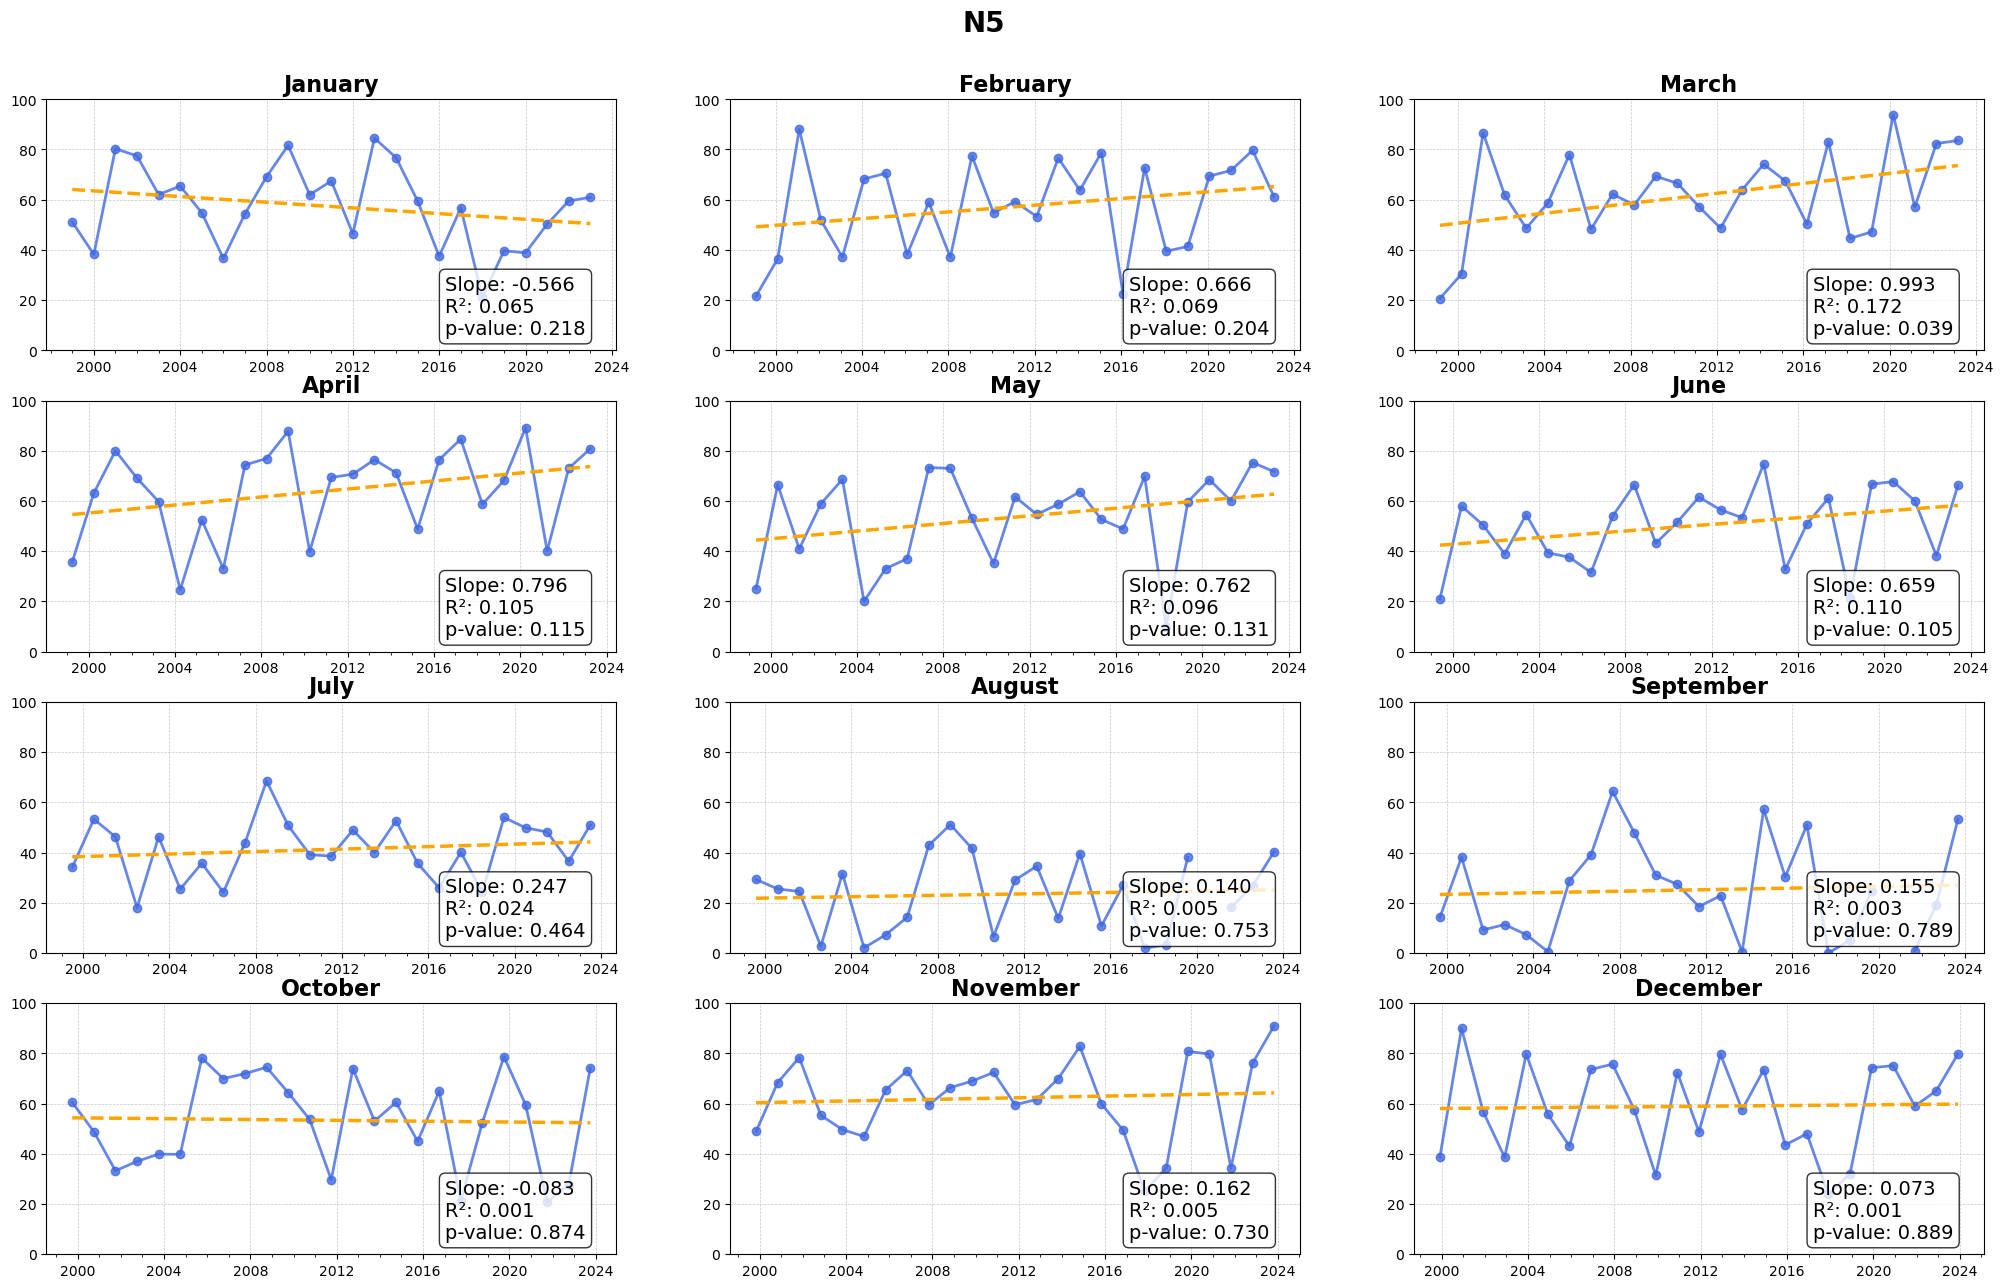

In [70]:

#for station_id in station_ids:
df_station = dfdict[station_id]
fig = plt.figure(figsize = (25,15))
fig.suptitle(f'{df_station["station_id"][0]}',fontweight = "bold",fontsize = 20,y = .94)

for i,month in enumerate(range(1,13)):
    sic_month = np.zeros((4,len(range(1999,2024))))
    for i,station_id in enumerate(stations_eg):
        df_station = dfdict[station_id]
        df_month = df_station[df_station["month"] == month]
        sic_month[i,:] = df_month["sic_mean"]
        df_month['dt'] = pd.to_datetime(df_month[['year', 'month']].assign(day=1))
    #sys.exit()
    #To dos:
        #- use average of sic_month instead iof df_month for linreg
        #- plot single data points of sic_month together with mean line
        #- plot map for each mo
                  #nth                                               
    # Extract the dt array for plotting
    dt_array = df_month['dt'].values
    
    ax = fig.add_subplot(4,3,month)
    #ax.set_title(, fontsize=16, fontweight='bold')
    ax.plot(dt_array,df_month["sic_mean"],color='royalblue', linestyle='-', marker='o', markersize=6, linewidth=2, alpha=0.8)
    ax.set_ylim((0,100))
    ax.set_title(f'{calendar.month_name[month]}', fontsize=16, fontweight='bold')
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    lr = linregress(df_month["year"][~np.isnan(df_month["sic_mean"])],df_month["sic_mean"][~np.isnan(df_month["sic_mean"])])
    #ax.text(0.75, 0.3, f"Slope: {lr.slope:.3f}", transform=ax.transAxes, fontsize=14, verticalalignment='top', horizontalalignment='left')
    ax.plot(dt_array,range(1999,2024)*lr.slope+lr.intercept, color='orange', linewidth=2.5, linestyle='--')
    stats_text = (f"Slope: {lr.slope:.3f}\n"
                   f"R²: {lr.rvalue**2:.3f}\n"
                   f"p-value: {lr.pvalue:.3f}")
    
    # Box properties for the text
    text_props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.8)
    
    # Add the text with a box around it
    ax.text(0.7, 0.3, stats_text,
            transform=ax.transAxes, fontsize=14,
            verticalalignment='top', horizontalalignment='left',
            bbox=text_props)

    # Improve x-axis formatting
    #plt.xticks(rotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    # Set major ticks to every year
    ax.xaxis.set_minor_locator(mdates.YearLocator())
#fig.savefig(os.path.join(plotdir,f"hausgarten_sic_mean_{station_id}_by_month_1999-2023.pdf"),dpi = 150,bbox_inches = "tight")
#plt.close(fig)
fig.show()
sys.exit("ONE STATION")